## Plot data

### HectorGravelPrime

Observation dimension is 49 \
Action dimension is 6 (centroidal linear acceleration, angular acceleration)

In [14]:
import os
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import numpy as np
# import torch

# Update Matplotlib's rcParams for paper-quality figures
mpl.rcParams.update({
    'font.family': 'serif',          # Use serif fonts (e.g., Times New Roman)
    'font.size': 9,                 # Base font size
    'axes.labelsize': 10,           # Font size for axis labels
    'axes.titlesize': 10,           # Font size for titles
    'xtick.labelsize': 8,           # Font size for x-axis tick labels
    'ytick.labelsize': 8,           # Font size for y-axis tick labels
    'legend.fontsize': 8,           # Font size for legend text
    'text.usetex': False,           # Use TeX for rendering text (set True for high-quality LaTeX output)
    'figure.dpi': 300,              # Higher resolution for publication
    'savefig.dpi': 300,             # Ensure saved figures have high resolution
    'figure.figsize': (3.5, 2.5),   # Set figure size to match journal column width
    'axes.linewidth': 0.8,          # Thinner axis lines for a clean look
    'legend.frameon': False,         # Remove the legend frame for a cleaner appearance
    'lines.linewidth': 1.5          # Thinner plot lines for a clean look
}) 

In [81]:
#######################
## process mpc data  ##
#######################

data_root = os.path.abspath("../../../logs/rsl_rl/ppo_rsl_rl_gru_soft/2025-01-31_16-54-04/logs/play_mpc/ema_0.97_v0.1")

state_dir = os.path.join(data_root, "state")
obs_dir = os.path.join(data_root, "obs")
action_dir = os.path.join(data_root, "action")
done_dir = os.path.join(data_root, "done")
rft_dir = os.path.join(data_root, "rft")

# collect all the data
state_files = glob.glob(os.path.join(state_dir, "*.pkl"))
obs_files = glob.glob(os.path.join(obs_dir, "*.pkl"))
action_files = glob.glob(os.path.join(action_dir, "*.pkl"))
done_files = glob.glob(os.path.join(done_dir, "*.pkl"))
rft_files = glob.glob(os.path.join(rft_dir, "*.pkl"))

# sort the files
state_files.sort()
obs_files.sort()
action_files.sort()
done_files.sort()
rft_files.sort()

# load the data
state_data = []
obs_data = []
mpc_action_data = []
action_data = []
rft_data = []
done_data = []

for i in range(len(state_files)):
    state_file = state_files[i]
    obs_file = obs_files[i]
    action_file = action_files[i]
    done_file = done_files[i]
    rft_file = rft_files[i]

    with open(state_file, "rb") as f:
        state = pickle.load(f)
    with open(obs_file, "rb") as f:
        obs = pickle.load(f)
    with open(action_file, "rb") as f:
        action = pickle.load(f)
    with open(done_file, "rb") as f:
        done = pickle.load(f)
    with open(rft_file, "rb") as f:
        rft = pickle.load(f)
    
    state = np.array(state)
    obs = np.array(obs)
    action = np.array(action)
    done = np.array(done)
    rft = np.array(rft)
    
    state_data.append(state) # (episode_length, state_dim)
    obs_data.append(obs) # (episode_length, obs_dim)
    action_data.append(action) # (episode_length, action_dim)
    mpc_action_data.append(obs[:, 50:56])
    done_data.append(done)
    rft_data.append(rft)

# fill missing time steps 
max_time_step = 2000-1
for i in range(len(state_data)):
    if len(state_data[i]) < max_time_step:
        state_data[i] = np.concatenate([state_data[i], np.tile(np.zeros_like(state_data[i][0:1]), (max_time_step - len(state_data[i]), 1, 1))], axis=0)
        obs_data[i] = np.concatenate([obs_data[i], np.tile(np.zeros_like(obs_data[i][0:1]), (max_time_step - len(obs_data[i]), 1, 1))], axis=0)
        action_data[i] = np.concatenate([action_data[i], np.tile(np.zeros_like(action_data[i][0:1]), (max_time_step - len(action_data[i]), 1, 1))], axis=0)
        mpc_action_data[i] = np.concatenate([mpc_action_data[i], np.tile(np.zeros_like(mpc_action_data[i][0:1]), (max_time_step - len(mpc_action_data[i]), 1, 1))], axis=0)
        done_data[i] = np.concatenate([done_data[i], np.tile(np.zeros((1, done_data[i].shape[-1])), (max_time_step - len(done_data[i]), 1))], axis=0)
        rft_data[i] = np.concatenate([rft_data[i], np.tile(np.zeros_like(rft_data[i][0:1]), (max_time_step - len(rft_data[i]), 1, 1, 1))], axis=0)

state_data = np.concatenate(state_data, axis=1) # (episode_length, num_agent, state_dim)
obs_data = np.concatenate(obs_data, axis=1) # (episode_length, num_agent, obs_dim)
action_data = np.concatenate(action_data, axis=1) # (episode_length, num_agent, action_dim)
mpc_action_data = np.concatenate(mpc_action_data, axis=1) # (episode_length, num_agent, action_dim)
done_data = np.concatenate(done_data, axis=1)
rft_data = np.concatenate(rft_data, axis=1)

In [82]:
state = state_data.transpose(1,0,2)
obs = obs_data.transpose(1,0,2)
action = action_data.transpose(1,0,2)
done = done_data.transpose(1,0)
rft = rft_data.transpose(1,0,2,3)

rft_depth = rft[:, :, :, 0]
rft_beta = rft[:, :, :, 1]
rft_gamma = rft[:, :, :, 2]
foot_vel = rft[:, :, :, 3:6]
foot_accel = rft[:, :, :, 6:9]
rft_force = rft[:, :, :, 9:]

print("==== baseline mpc ====")
print("number of envs: ", len(obs))
print("state dimension: ", state.shape)
print("observersation dimension: ", obs.shape)
print("action dimension: ", action.shape)
print("done shape", done.shape)
print("rft shape", rft.shape)

==== baseline mpc ====
number of envs:  2
state dimension:  (2, 1999, 33)
observersation dimension:  (2, 1999, 60)
action dimension:  (2, 1999, 6)
done shape (2, 1999)
rft shape (2, 1999, 8, 12)


In [83]:
# observation indices
height_indies = 0
orientation_indies = slice(1, 5)
linear_velocity_indies = slice(5, 7)
angular_velocity_indies = 10
desired_linear_velocity_indies = slice(11, 13)
desired_angular_velocity_indies = 13
joint_pos_indies = slice(14, 24)
joint_vel_indies = slice(24, 34)
jont_effort_indices = slice(34, 44)
previous_action_indies = slice(44, 50)
mpc_action_indies = slice(50, 56)
gait_contact_indices = slice(56, 58)
gt_contact_indices = slice(58, 60)

# state indices
state_position_indices = slice(0, 3)

velocity_x = obs[:, :, linear_velocity_indies][:, :, 0]
desired_velocity_x = obs[:, :, desired_linear_velocity_indies][:, :, 0]

ang_velocity = obs[:, :, angular_velocity_indies]
desired_ang_velocity = obs[:, :, desired_angular_velocity_indies]

### Plot Result

In [84]:
# max_step = 2000

# alive_step = []
# for i in range(done.shape[0]):
#     step = np.argwhere(done[i])
#     if len(step) >0:
#         alive_step.append(step[0, 0]+2)
#     else:
#         alive_step.append(0)
        
# alive_step = np.array(alive_step)
# success_rate = alive_step/max_step
# mean_success_rate = success_rate.mean()
# sucess_rate_std = success_rate.std()
# print("alive rate", mean_success_rate)
# print("alive rate std", sucess_rate_std)

# if np.max(alive_step) == max_step:
#     alive_idx = np.squeeze(np.argwhere(alive_step==max_step))
#     vel_x_alive = velocity_x[alive_idx]
#     desired_vel_x_alive = desired_velocity_x[alive_idx]
#     ang_vel_alive = ang_velocity[alive_idx]
#     desired_ang_vel_alive = desired_ang_velocity[alive_idx]

#     vel_x_tracking_error = np.abs(vel_x_alive-desired_vel_x_alive)[:, :-1]
#     ang_vel_tracking_error = np.abs(ang_vel_alive-desired_ang_vel_alive)[:, :-1]

#     mean_vel_x_tracking_error = np.mean(vel_x_tracking_error)
#     std_vel_x_tracking_error = np.std(vel_x_tracking_error)
#     mean_ang_vel_tracking_error = np.mean(ang_vel_tracking_error)
#     std_ang_vel_tracking_error = np.std(ang_vel_tracking_error)

#     print("mean vx tracking error", mean_vel_x_tracking_error)
#     print("std vx tracking error", std_vel_x_tracking_error)
#     print("mean ang vel tracking error", mean_ang_vel_tracking_error)
#     print("std ang velocity tracking error", std_ang_vel_tracking_error)
# else:
#     print("all trial failed")

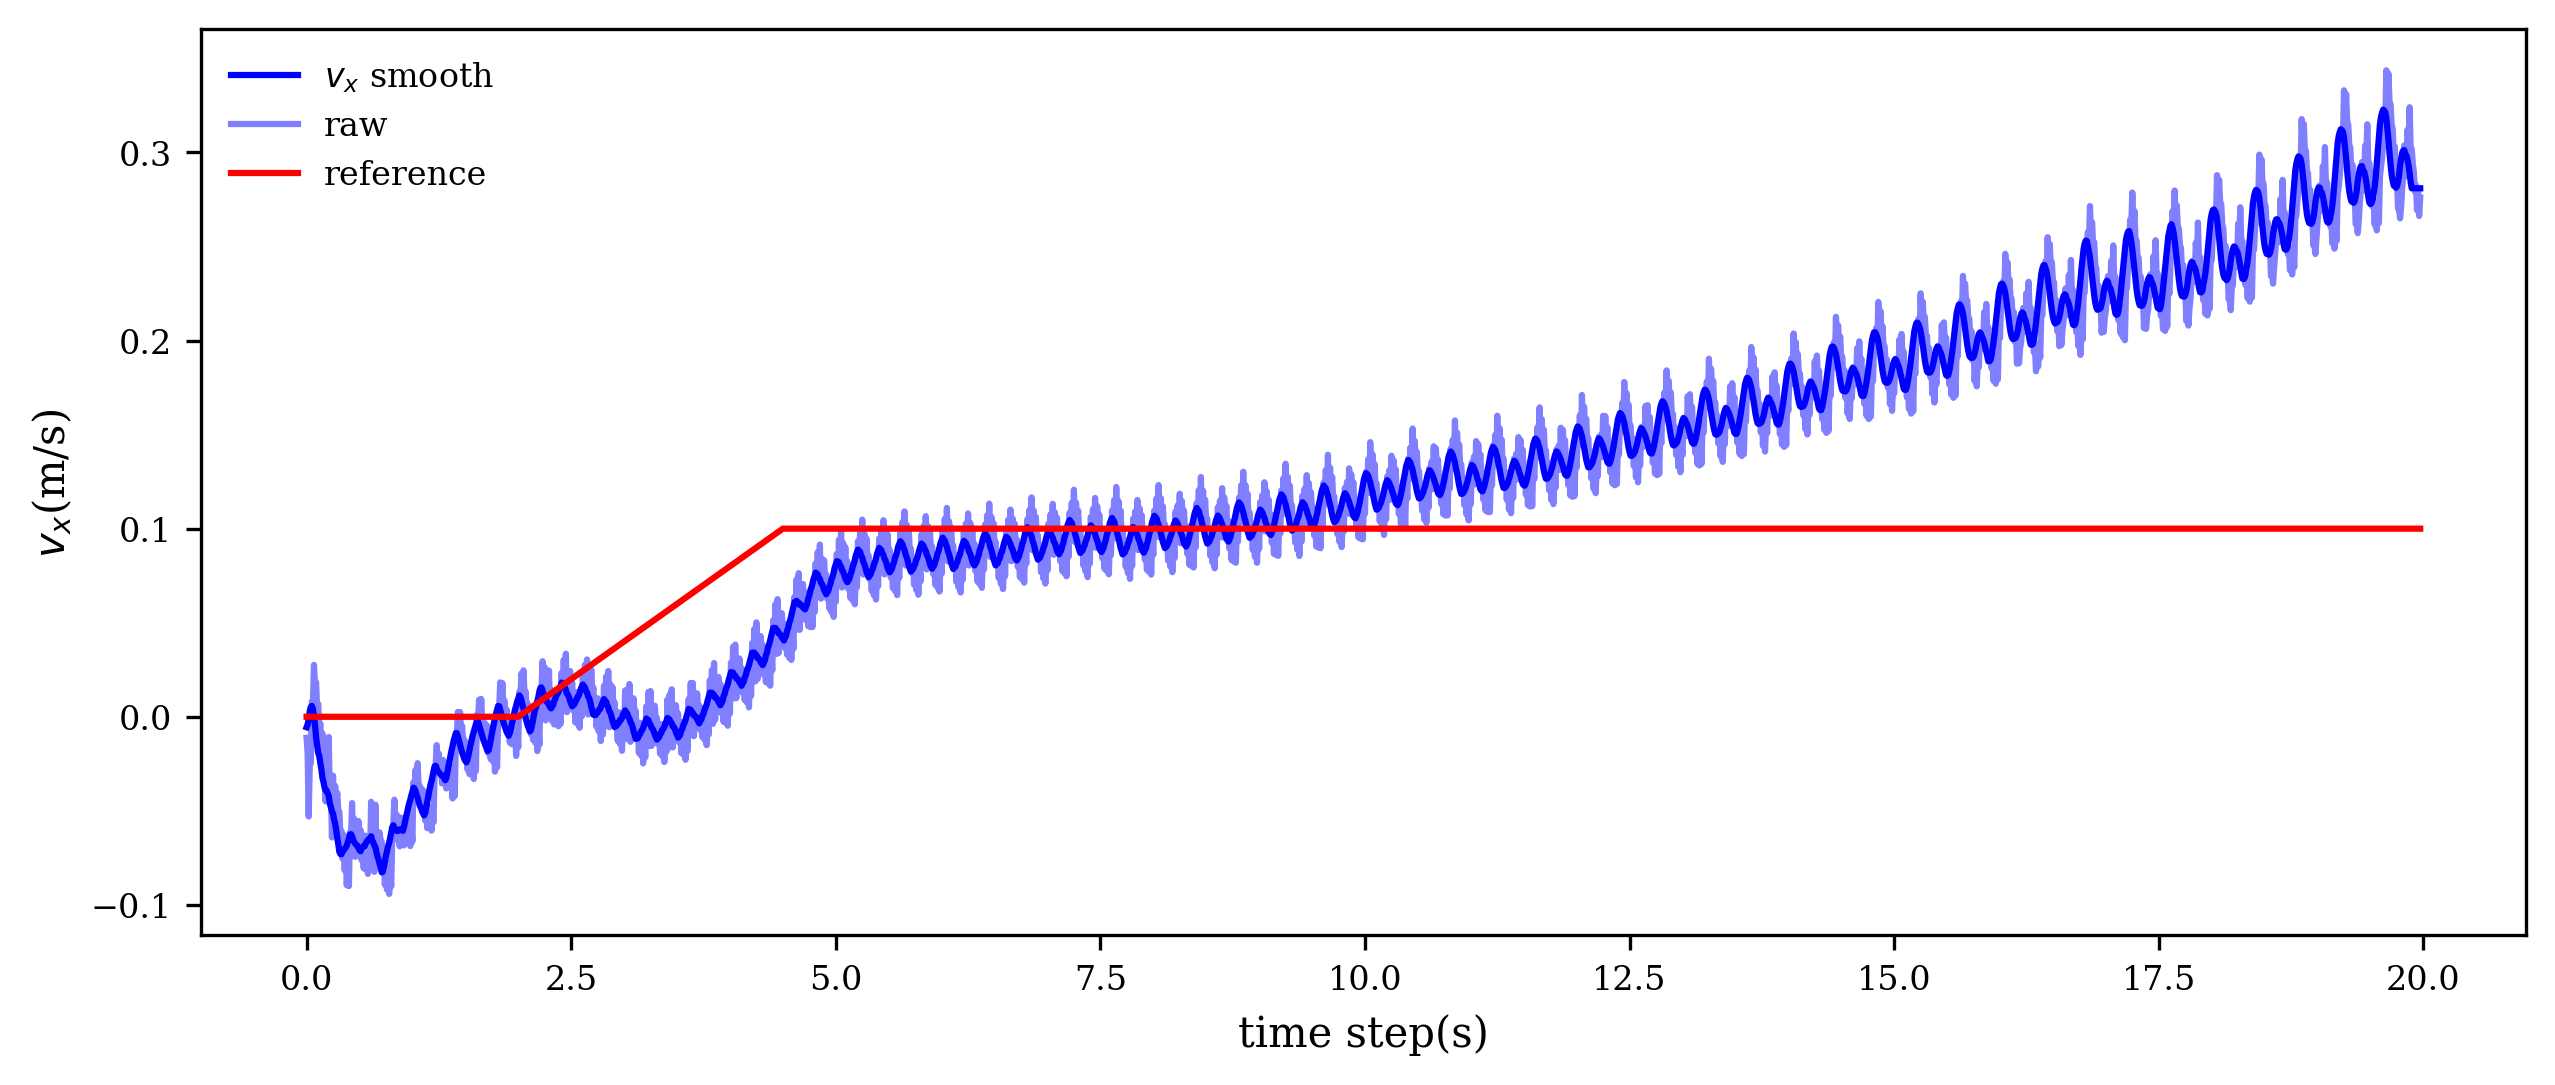

In [85]:
plt.figure(figsize=(10, 4))
use_moving_average = True
filter_size = 10
num_sample = 1
# num_sample = len(velocity_x)
for i in range(num_sample):
    t = (5 * 1/500) * np.arange(velocity_x[i].shape[0])
    if not use_moving_average:
        vx = velocity_x[i]
    else:
        vx = np.convolve(velocity_x[i], np.ones(filter_size)/filter_size, mode='valid')
        # fill missing data
        vx = np.concatenate([vx, np.tile(vx[-1], (len(velocity_x[i]) - len(vx)))], axis=0)
    plt.plot(t[:-1], vx[:-1], label=r"$v_x$ smooth", color="b")
    plt.plot(t[:-1], velocity_x[i][:-1], label="raw", color="b", alpha=0.5)
    plt.plot(t[:-1], desired_velocity_x[i][:-1], label="reference", color="r")
    plt.legend()
    plt.xlabel("time step(s)")
    plt.ylabel(r"$v_x$(m/s)")
plt.savefig("vx_tracking_rft.png")
plt.show()

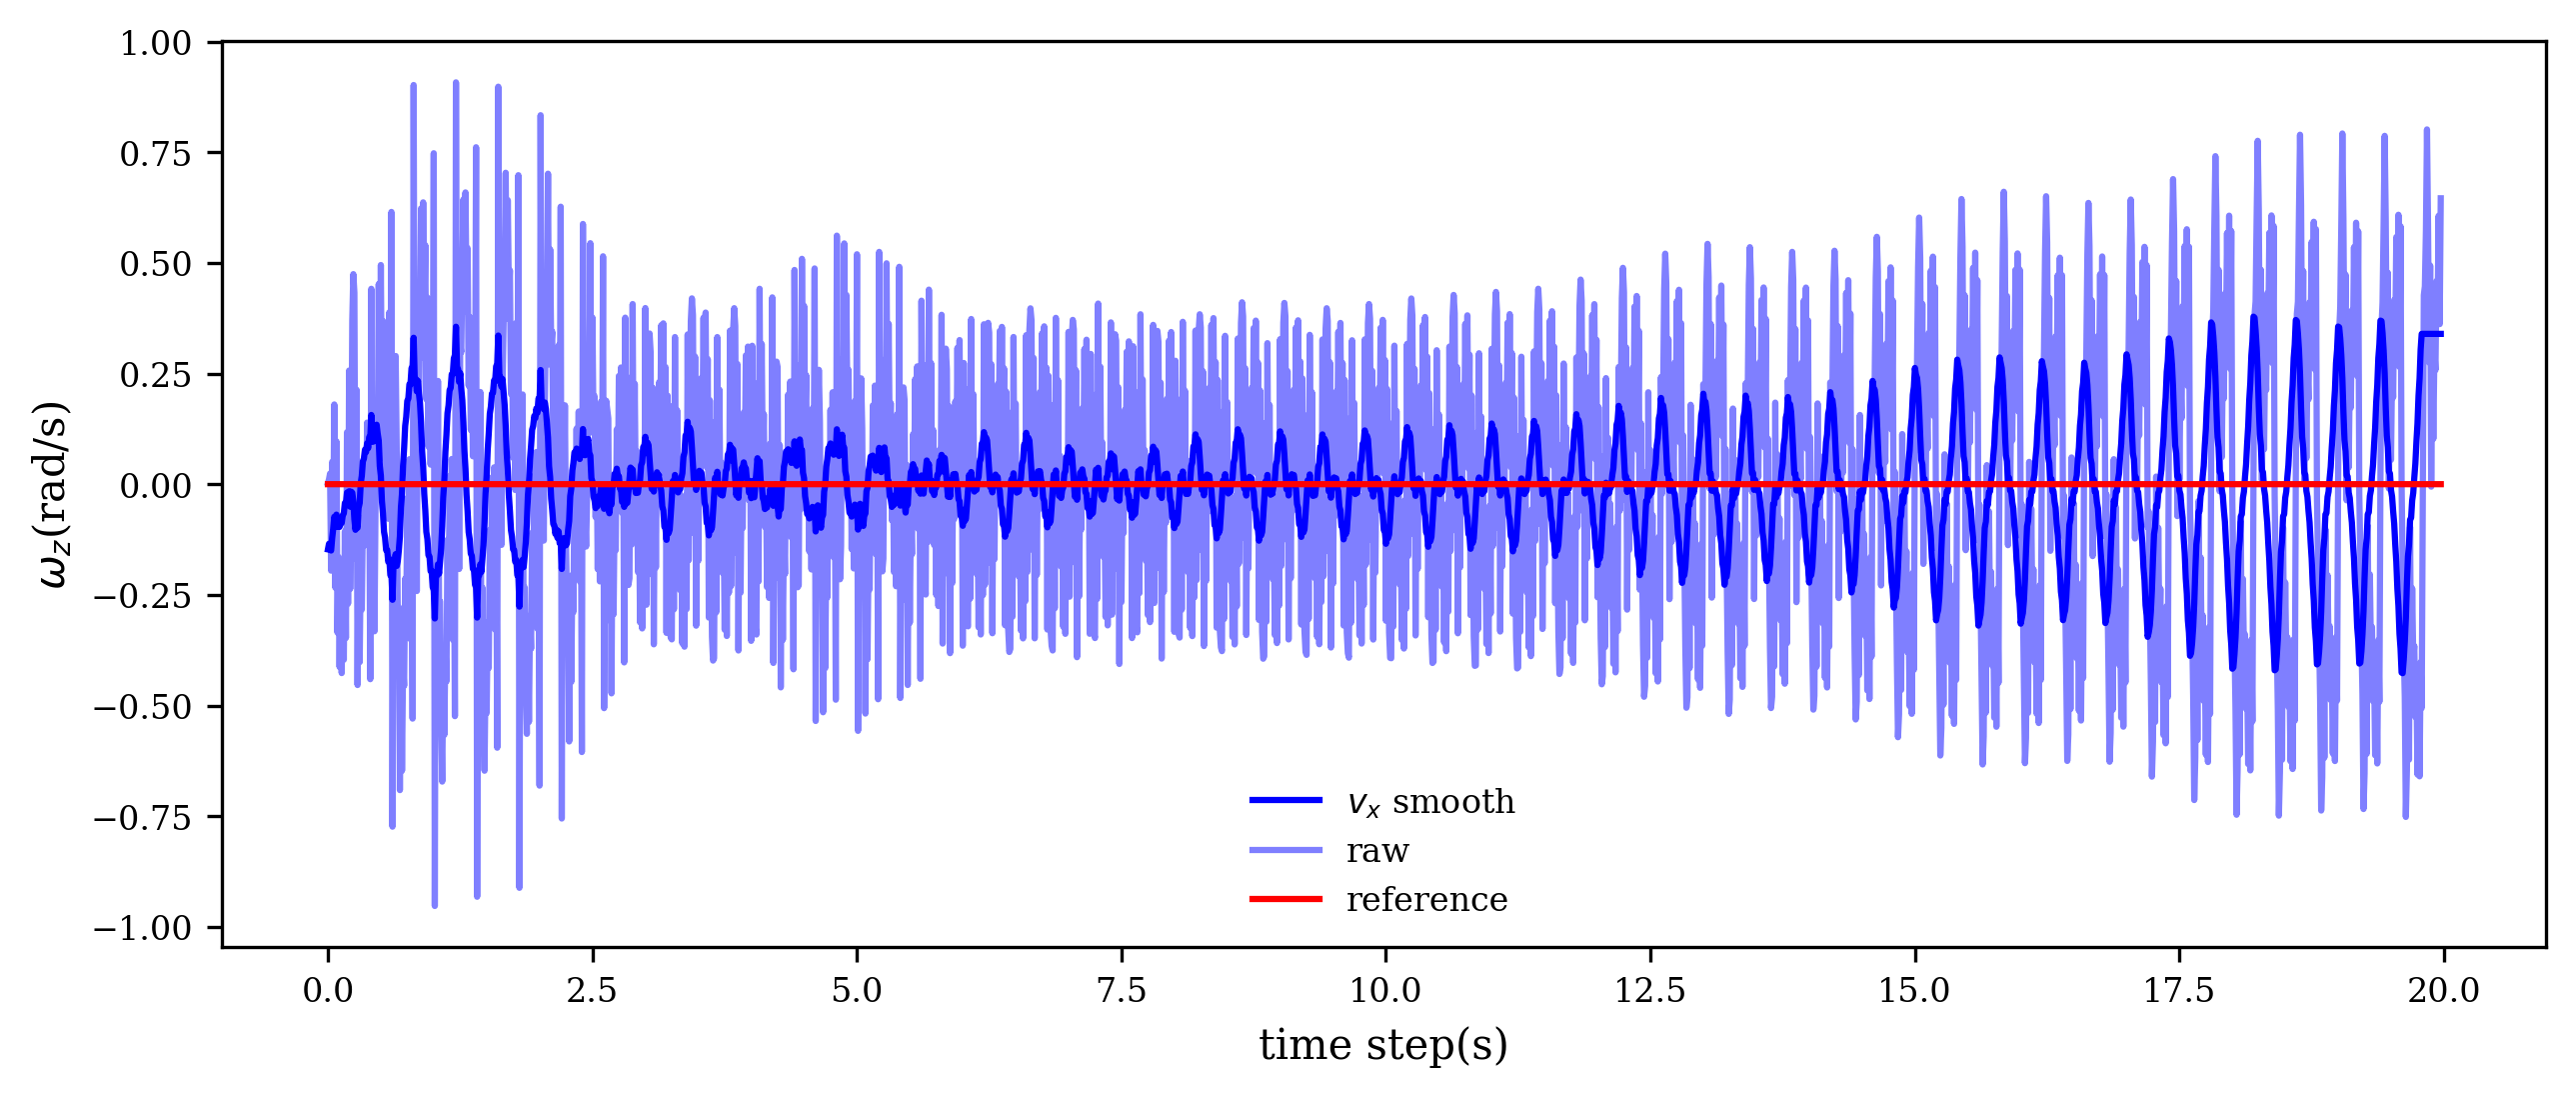

In [78]:
plt.figure(figsize=(10, 4))
use_moving_average = True
filter_size = 20
num_sample = 1
# num_sample = len(velocity_x)
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(ang_velocity[i].shape[0]) 
    if not use_moving_average:
        wz = ang_velocity[i]
    else:
        wz = np.convolve(ang_velocity[i], np.ones(filter_size)/filter_size, mode='valid')
        # fill missing data
        wz = np.concatenate([wz, np.tile(wz[-1], (len(ang_velocity[i]) - len(wz)))], axis=0)

    plt.plot(t[:-1], wz[:-1], label=r"$v_x$ smooth", color="b")
    plt.plot(t[:-1], ang_velocity[i][:-1], label="raw", color="b", alpha=0.5)
    plt.plot(t[:-1], desired_ang_velocity[i][:-1], label="reference", color="r")
    plt.legend()
    plt.xlabel("time step(s)")
    plt.ylabel(r"$\omega_z$(rad/s)")
plt.savefig("wz_tracking_rft.png")
plt.show()

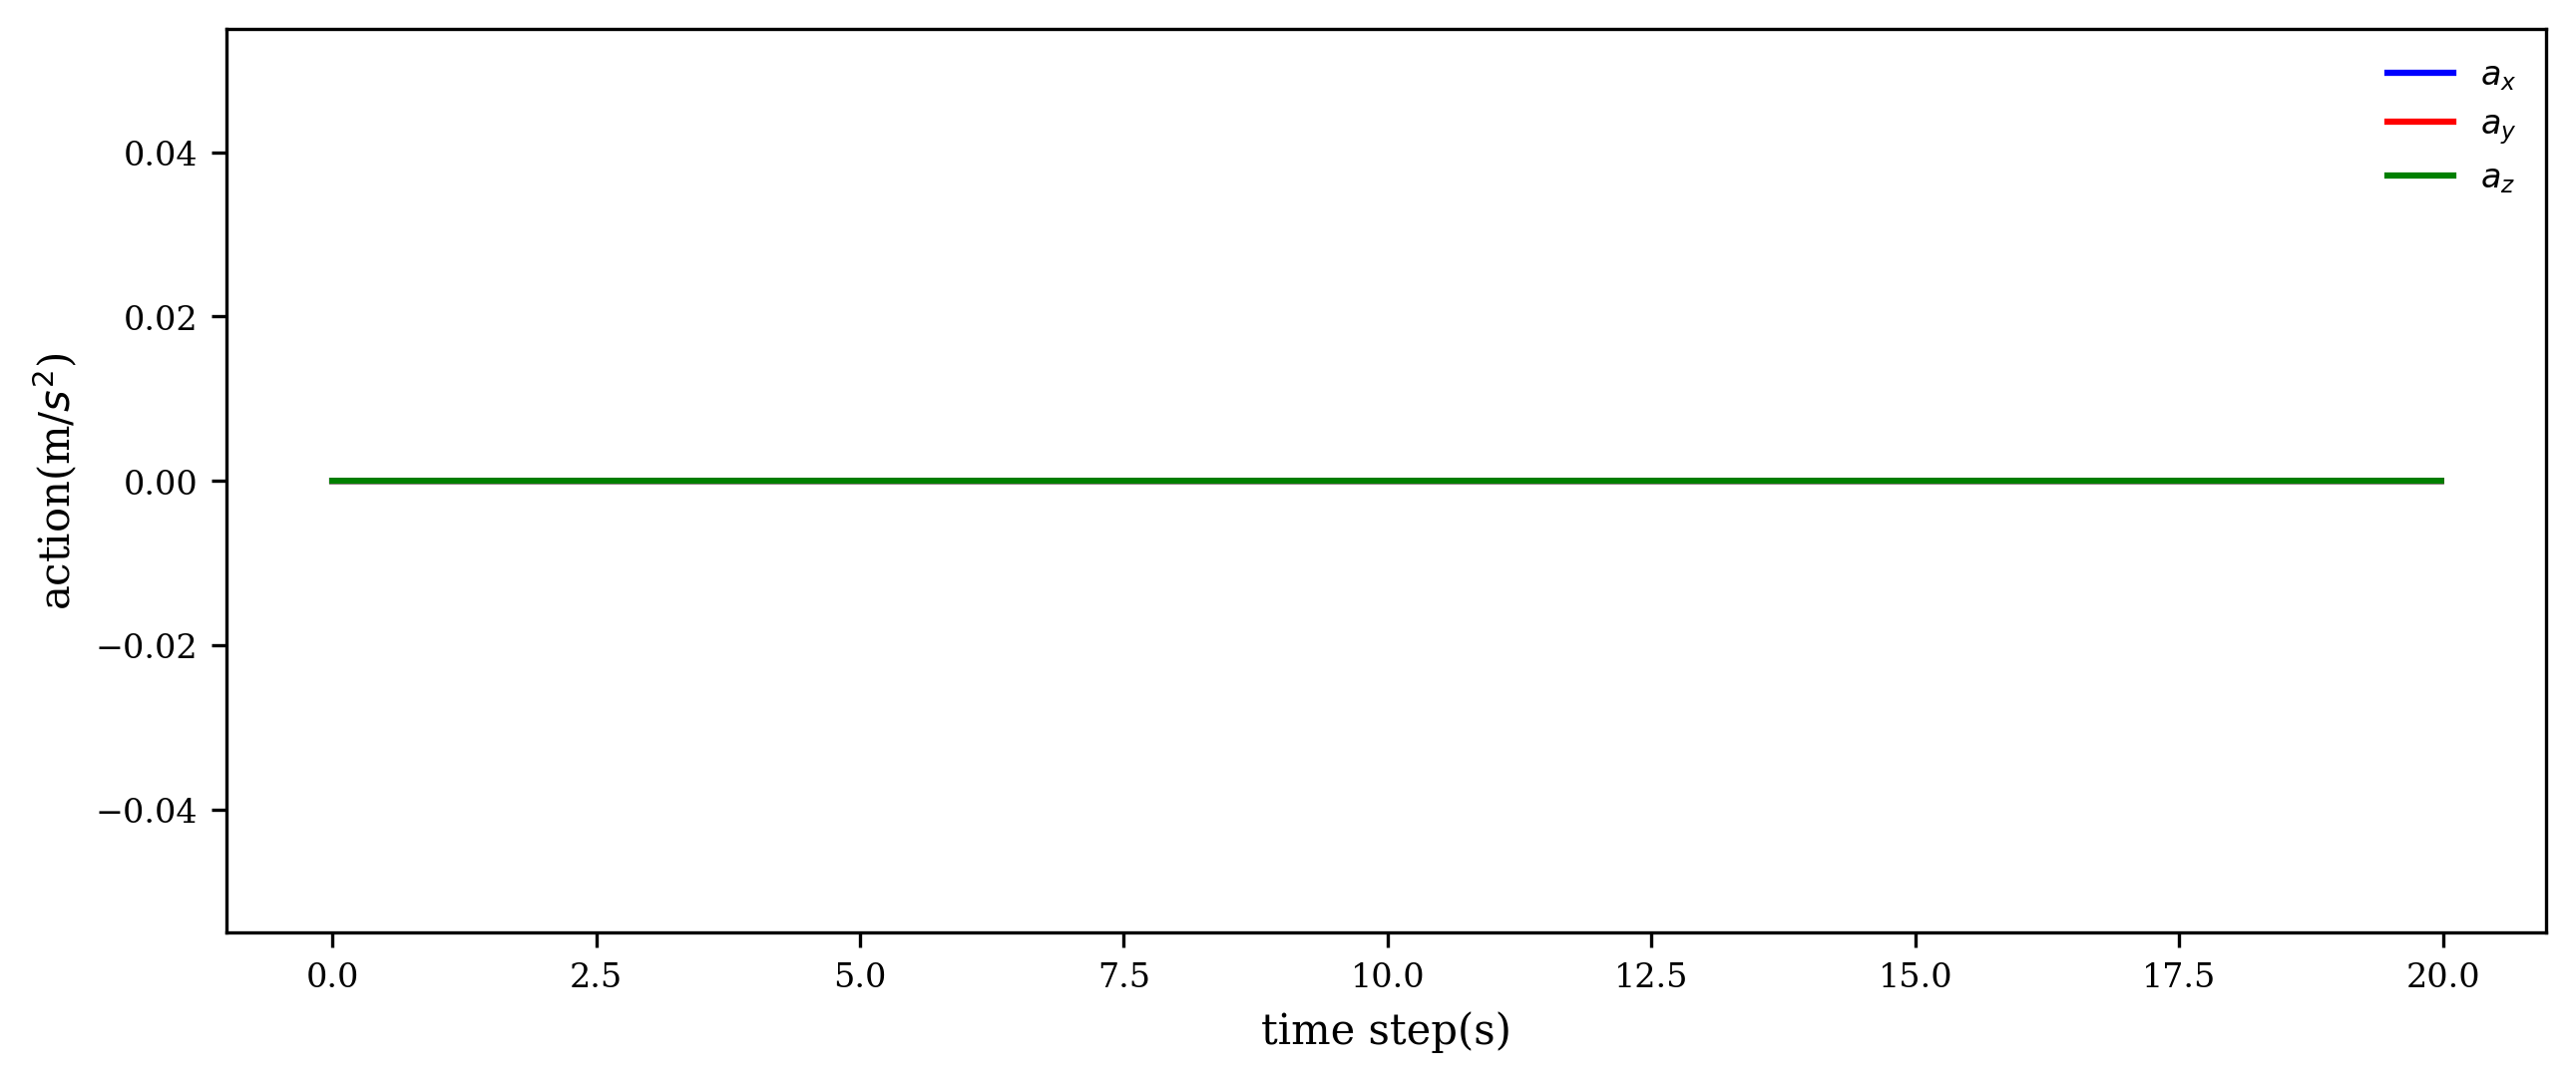

In [79]:
from copy import copy
plt.figure(figsize=(10, 4))
use_moving_average = True
filter_size = 20

num_sample = 1
for i in range(num_sample): 
    t = (5 * 1/500) * np.arange(action[i].shape[0]) 
    if not use_moving_average:
        a = copy(action[i])
    else:
        a = copy(action[i])
        for n in range(6):
            tmp = np.convolve(a[:, n], np.ones((filter_size))/filter_size, mode='valid')
            a[:, n] = np.concatenate([tmp, np.tile(tmp[-1], (len(action[i]) - len(tmp)))], axis=0)

    plt.plot(t, a[:, 0], label=r"$a_x$", color="blue")
    plt.plot(t, a[:, 1], label=r"$a_y$", color="red")
    plt.plot(t, a[:, 2], label=r"$a_z$", color="green")
    plt.xlabel("time step(s)")
    plt.ylabel(r"action(m/$s^2$)")
plt.legend()
plt.show()

### Plot RFT force

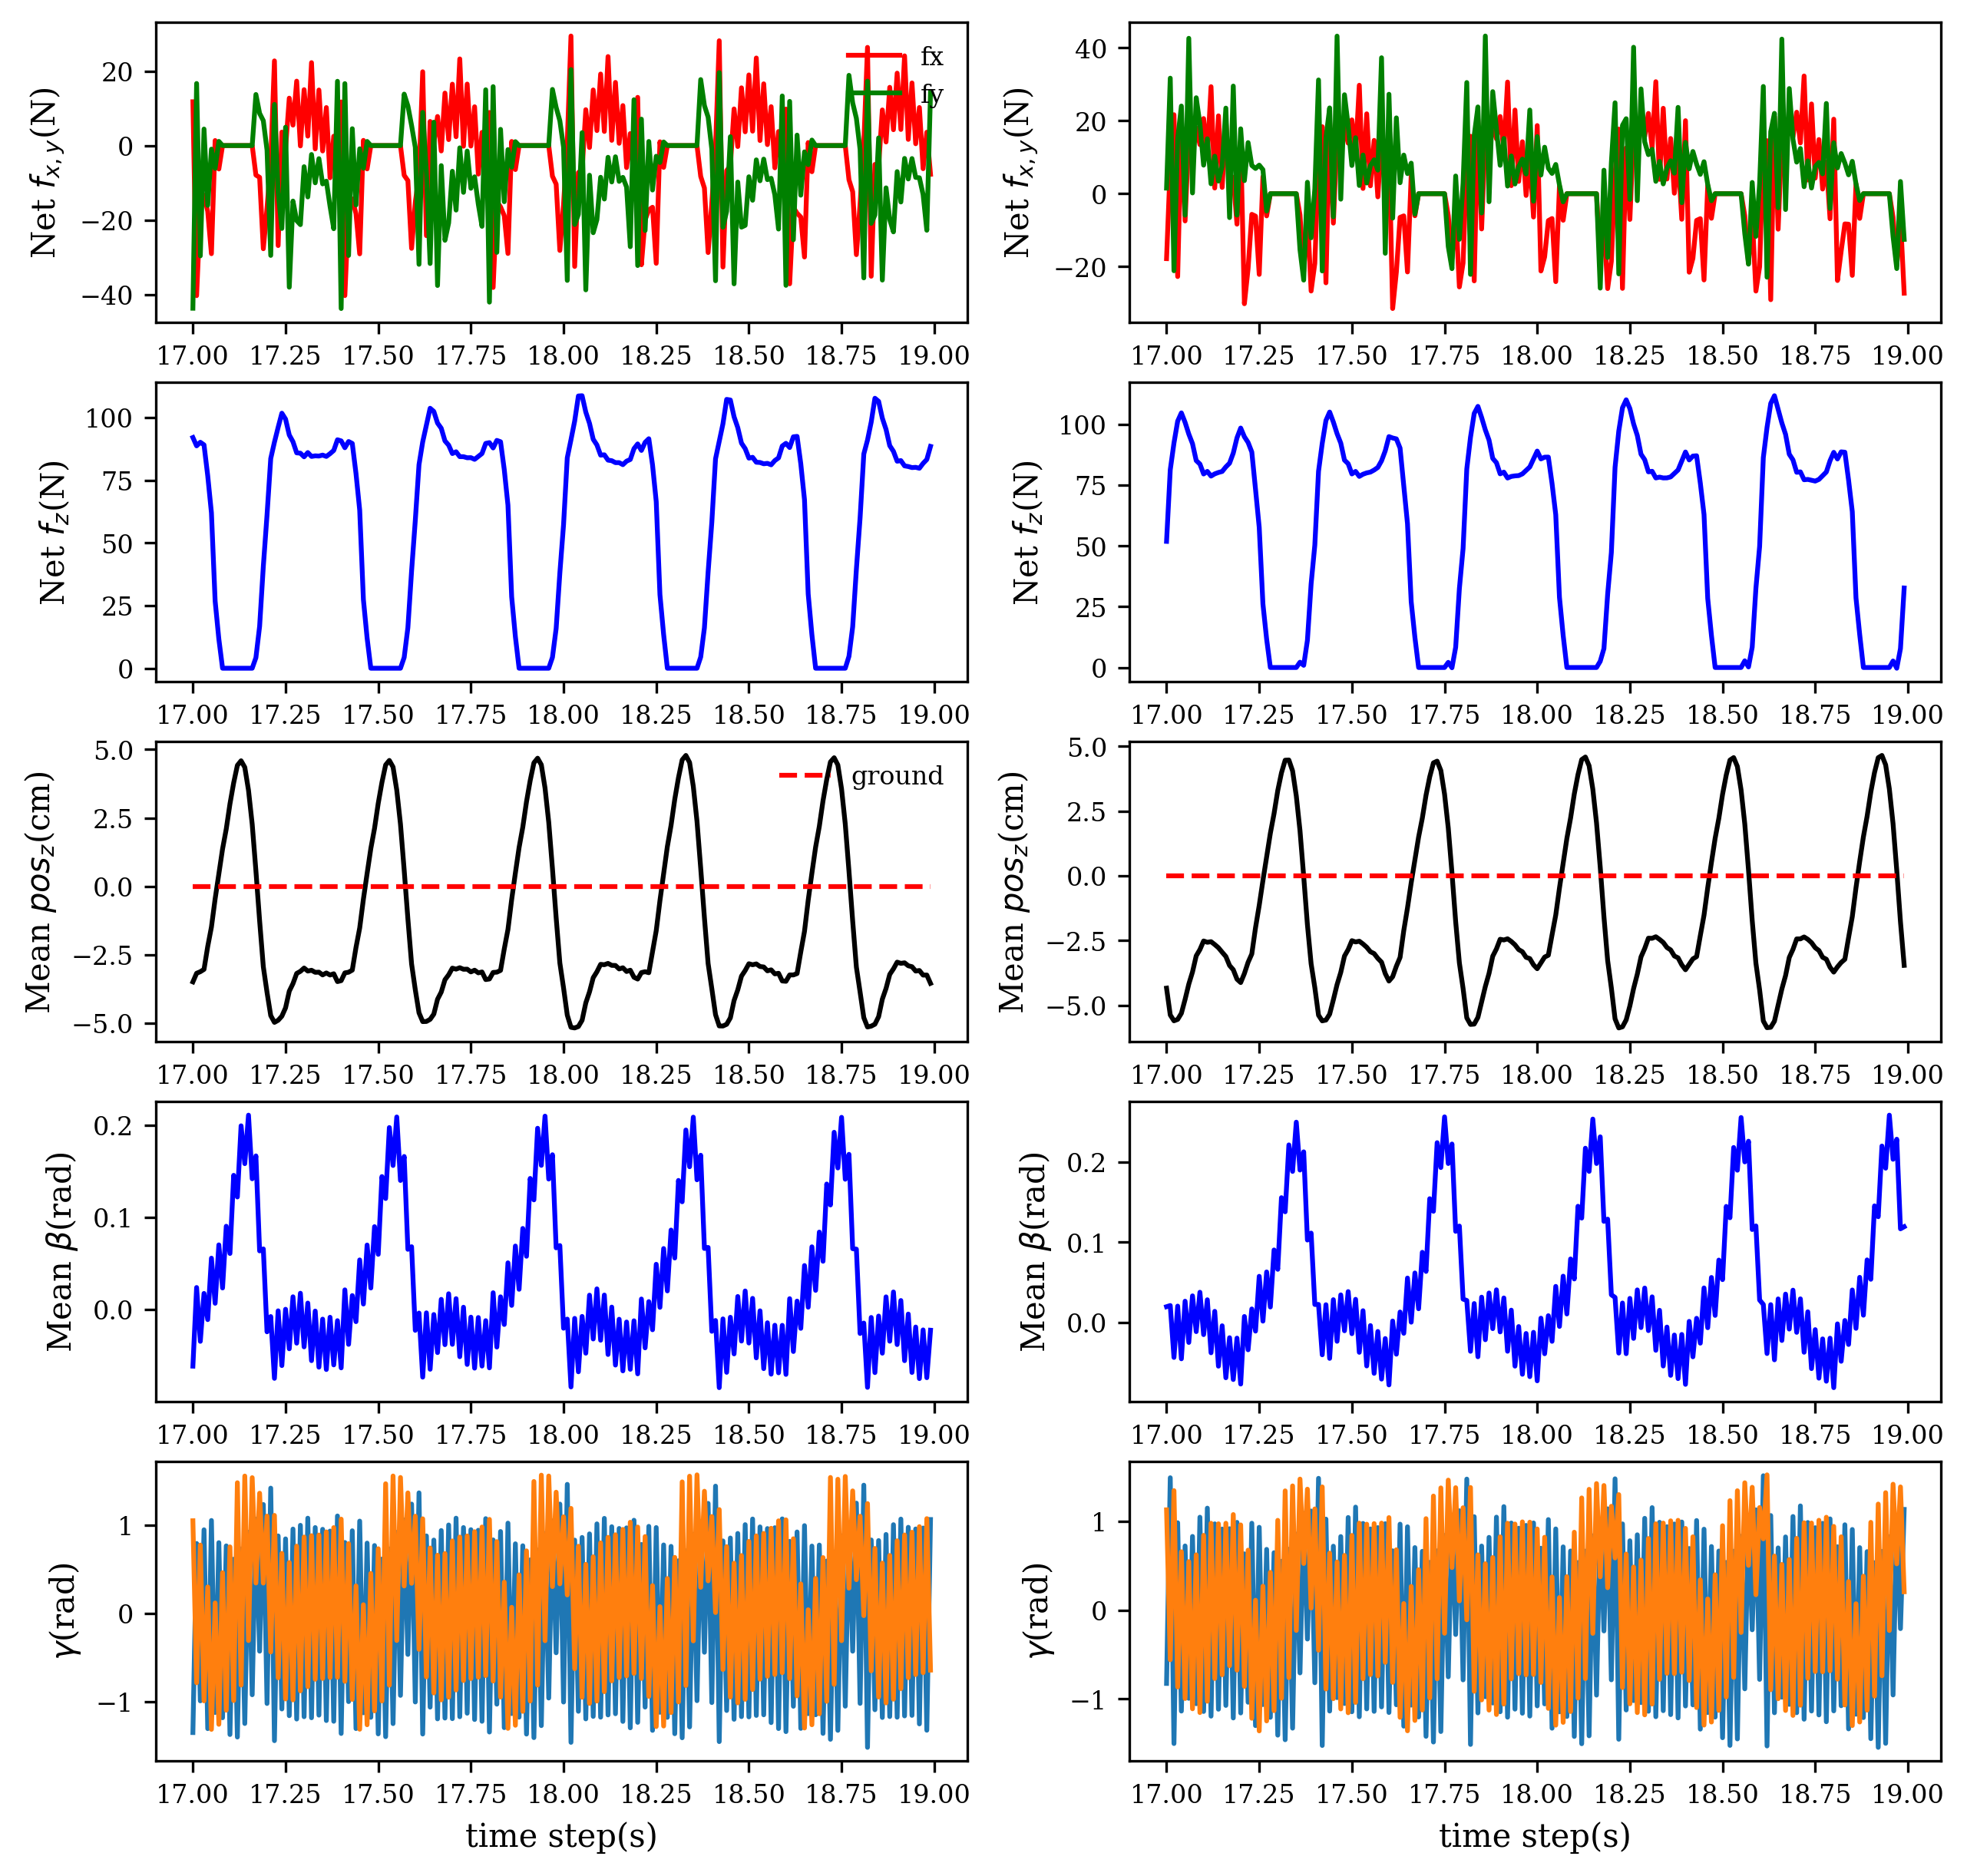

In [91]:
left_rft_force = np.sum(rft_force[:, :, :4, :], axis=2)
right_rft_force = np.sum(rft_force[:, :, 4:, :], axis=2)
left_depth = np.mean(rft_depth[:, :, :4], axis=2)
right_depth = np.mean(rft_depth[:, :, 4:], axis=2)

left_beta = np.mean(rft_beta[:, :, :4], axis=2)
right_beta = np.mean(rft_beta[:, :, 4:], axis=2)
left_gamma = rft_gamma[:, :, :4]
right_gamma = rft_gamma[:, :, 4:]

left_rft_force_x = left_rft_force[:, :, 0]
left_rft_force_y = left_rft_force[:, :, 1]
left_rft_force_z = left_rft_force[:, :, 2]

right_rft_force_x = right_rft_force[:, :, 0]
right_rft_force_y = right_rft_force[:, :, 1]
right_rft_force_z = right_rft_force[:, :, 2]

plt.figure(figsize=(10, 10))
use_moving_average = False
filter_size = 20
num_sample = 1
for i in range(num_sample):
    t = (5 * 1/500) * np.arange(left_rft_force_x[i].shape[0])
    left_x = left_rft_force_x[i]
    left_y = left_rft_force_y[i]
    left_z = left_rft_force_z[i]
    right_x = right_rft_force_x[i]
    right_y = right_rft_force_y[i]
    right_z = right_rft_force_z[i]
    
    t_start = 1700
    cut_off = 200
    time_range = np.arange(t_start, t_start+cut_off)
    
    plt.subplot(5, 2, 1)
    plt.plot(t[time_range], left_x[time_range], label="fx", color="r")
    plt.plot(t[time_range], left_y[time_range], label="fy", color="g")
    plt.ylabel(r"Net $f_{x,y}$(N)")
    plt.legend(loc="upper right")
    
    plt.subplot(5, 2, 3)
    plt.plot(t[time_range], left_z[time_range], label="fz", color="b")
    plt.ylabel(r"Net $f_z$(N)")
    
    plt.subplot(5, 2, 5)
    plt.plot(t[time_range], 100*left_depth[i][time_range], color="black")
    plt.plot(t[time_range], -0.01*np.ones_like(left_depth[i][time_range]), label="ground", color="r", linestyle="--")
    plt.legend()
    plt.ylabel(r"Mean $pos_z$(cm)")
    
    plt.subplot(5, 2, 7)
    plt.plot(t[time_range], left_beta[i][time_range], color="blue")
    plt.ylabel(r"Mean $\beta$(rad)")
    
    plt.subplot(5, 2, 9)
    plt.plot(t[time_range], left_gamma[i, time_range, 0])
    plt.plot(t[time_range], left_gamma[i, time_range, 1])
    # plt.plot(t[time_range], left_gamma[i, time_range, 2]) # similar with 0
    # plt.plot(t[time_range], left_gamma[i, time_range, 3]) # similar with 1
    plt.ylabel(r"$\gamma$(rad)")
    
    
    plt.xlabel("time step(s)")

    plt.subplot(5, 2, 2)
    plt.plot(t[time_range], right_x[time_range], label="right foot force x", color="r")
    plt.plot(t[time_range], right_y[time_range], label="right foot force y", color="g")
    plt.ylabel(r"Net $f_{x,y}$(N)")
    
    plt.subplot(5, 2, 4)
    plt.plot(t[time_range], right_z[time_range], label="right foot force z", color="b")
    plt.ylabel(r"Net $f_z$(N)")
    
    plt.subplot(5, 2, 6)
    plt.plot(t[time_range], 100*right_depth[i][time_range], color="black")
    plt.plot(t[time_range], -0.01*np.ones_like(right_depth[i][time_range]), color="r", linestyle="--")
    plt.ylabel(r"Mean $pos_z$(cm)")
    
    plt.subplot(5, 2, 8)
    plt.plot(t[time_range], right_beta[i][time_range], color="blue")
    plt.ylabel(r"Mean $\beta$(rad)")
    
    plt.subplot(5, 2, 10)
    plt.plot(t[time_range], right_gamma[i, time_range, 0])
    plt.plot(t[time_range], right_gamma[i, time_range, 1])
    # plt.plot(t[time_range], right_gamma[i, time_range, 2])
    # plt.plot(t[time_range], right_gamma[i, time_range, 3])
    plt.ylabel(r"$\gamma$(rad)")
    
    
    plt.xlabel("time step(s)")

t_start = int(t[time_range][0])
t_end = int(t[time_range][-1])
plt.savefig(f"rft_force_profile_t={t_start}_{t_end}s.png")
plt.show()

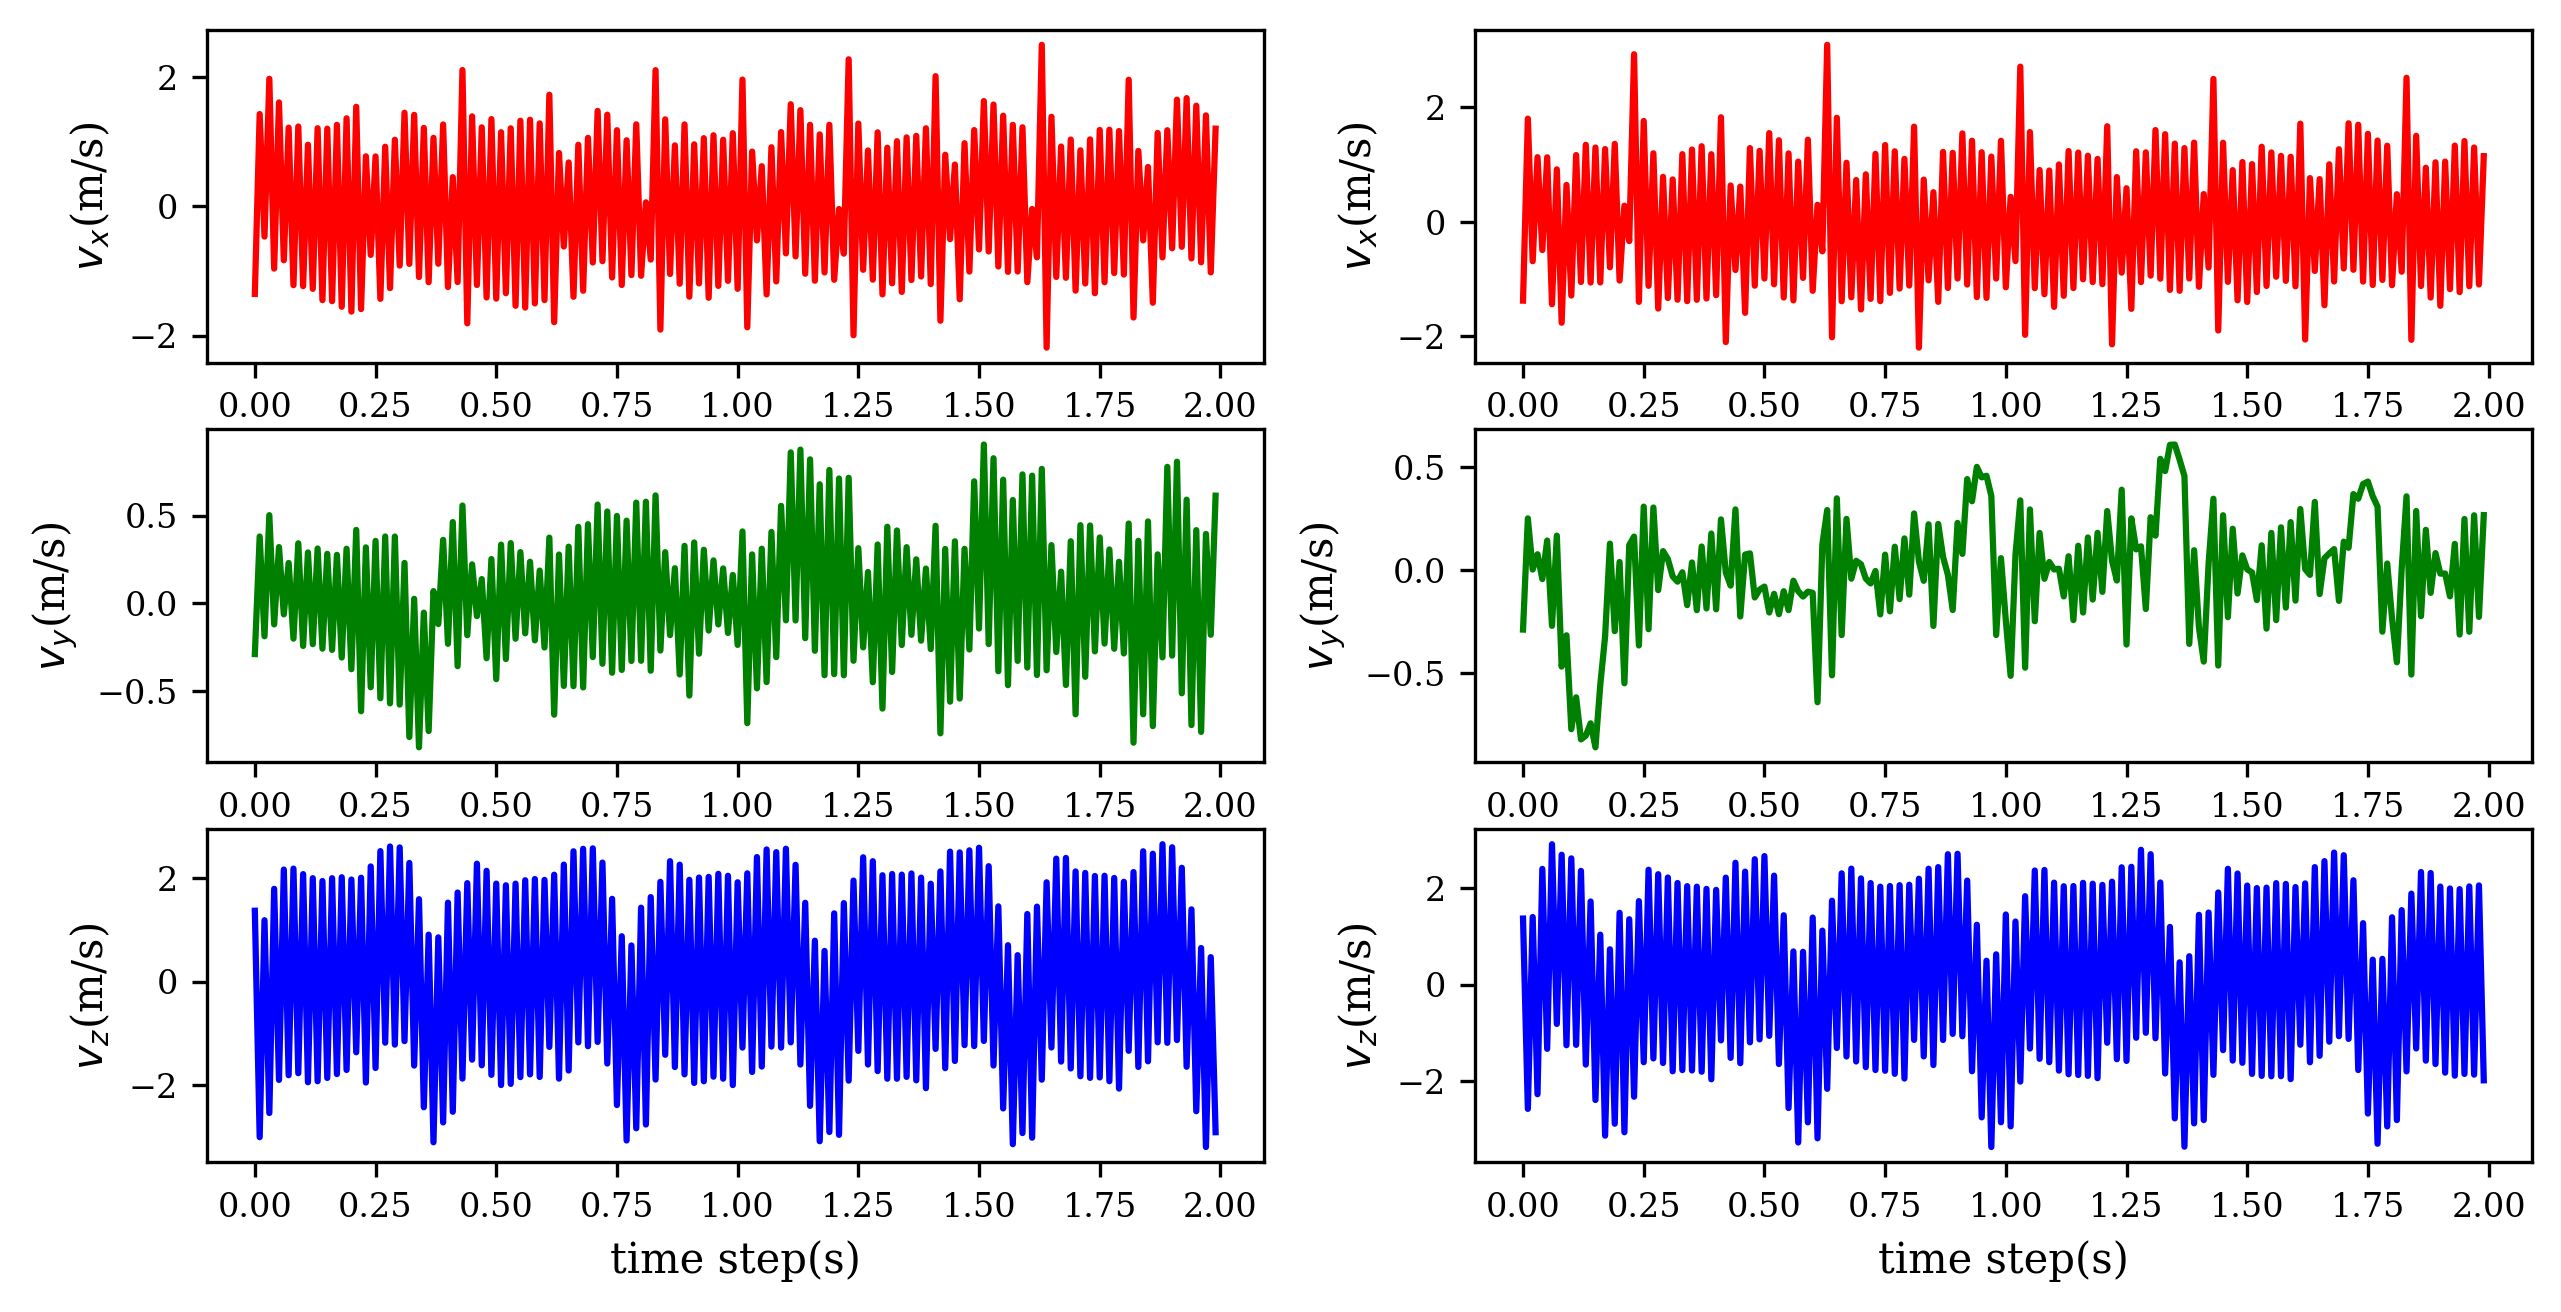

In [59]:
# left_vel = foot_vel[:, :, :4, :].mean(axis=2)
# right_vel = foot_vel[:, :, 4:, :].mean(axis=2)
# left_accel = foot_accel[:, :, :4, :].mean(axis=2)
# right_accel = foot_accel[:, :, 4:, :].mean(axis=2)

chunk_id = 0
left_vel = foot_vel[:, :, chunk_id, :]
right_vel = foot_vel[:, :, 4+chunk_id, :]
left_accel = foot_accel[:, :, chunk_id, :]
right_accel = foot_accel[:, :, 4+chunk_id, :]

left_vel_x = left_vel[:, :, 0]
left_vel_y = left_vel[:, :, 1]
left_vel_z = left_vel[:, :, 2]

right_vel_x = right_vel[:, :, 0]
right_vel_y = right_vel[:, :, 1]
right_vel_z = right_vel[:, :, 2]

plt.figure(figsize=(10, 5))
use_moving_average = False
filter_size = 20
num_sample = 1

for i in range(num_sample):
    t = (5 * 1/500) * np.arange(left_vel_x[i].shape[0])
    
    left_vx = left_vel_x[i]
    left_vy = left_vel_y[i]
    left_vz = left_vel_z[i]
    
    right_vx = right_vel_x[i]
    right_vy = right_vel_y[i]
    right_vz = right_vel_z[i]
    
    t_start = 0
    cut_off = 200
    time_range = np.arange(t_start, t_start+cut_off)
    
    plt.subplot(3, 2, 1)
    plt.plot(t[time_range], left_vx[time_range], label="vx", color="r")
    plt.ylabel(r"$v_x$(m/s)")
    
    plt.subplot(3, 2, 2)
    plt.plot(t[time_range], right_vx[time_range], label="vx", color="r")
    plt.ylabel(r"$v_x$(m/s)")
    
    plt.subplot(3, 2, 3)
    plt.plot(t[time_range], left_vy[time_range], label="vy", color="g")
    plt.ylabel(r"$v_y$(m/s)")
    
    plt.subplot(3, 2, 4)
    plt.plot(t[time_range], right_vy[time_range], label="vy", color="g")
    plt.ylabel(r"$v_y$(m/s)")
    
    plt.subplot(3, 2, 5)
    plt.plot(t[time_range], left_vz[time_range], label="vz", color="b")
    plt.ylabel(r"$v_z$(m/s)")
    plt.xlabel("time step(s)")
    
    plt.subplot(3, 2, 6)
    plt.plot(t[time_range], right_vz[time_range], label="vz", color="b")
    plt.ylabel(r"$v_z$(m/s)")
    plt.xlabel("time step(s)")
    
# plt.savefig("foot_vel_profile.png")
plt.show()
    


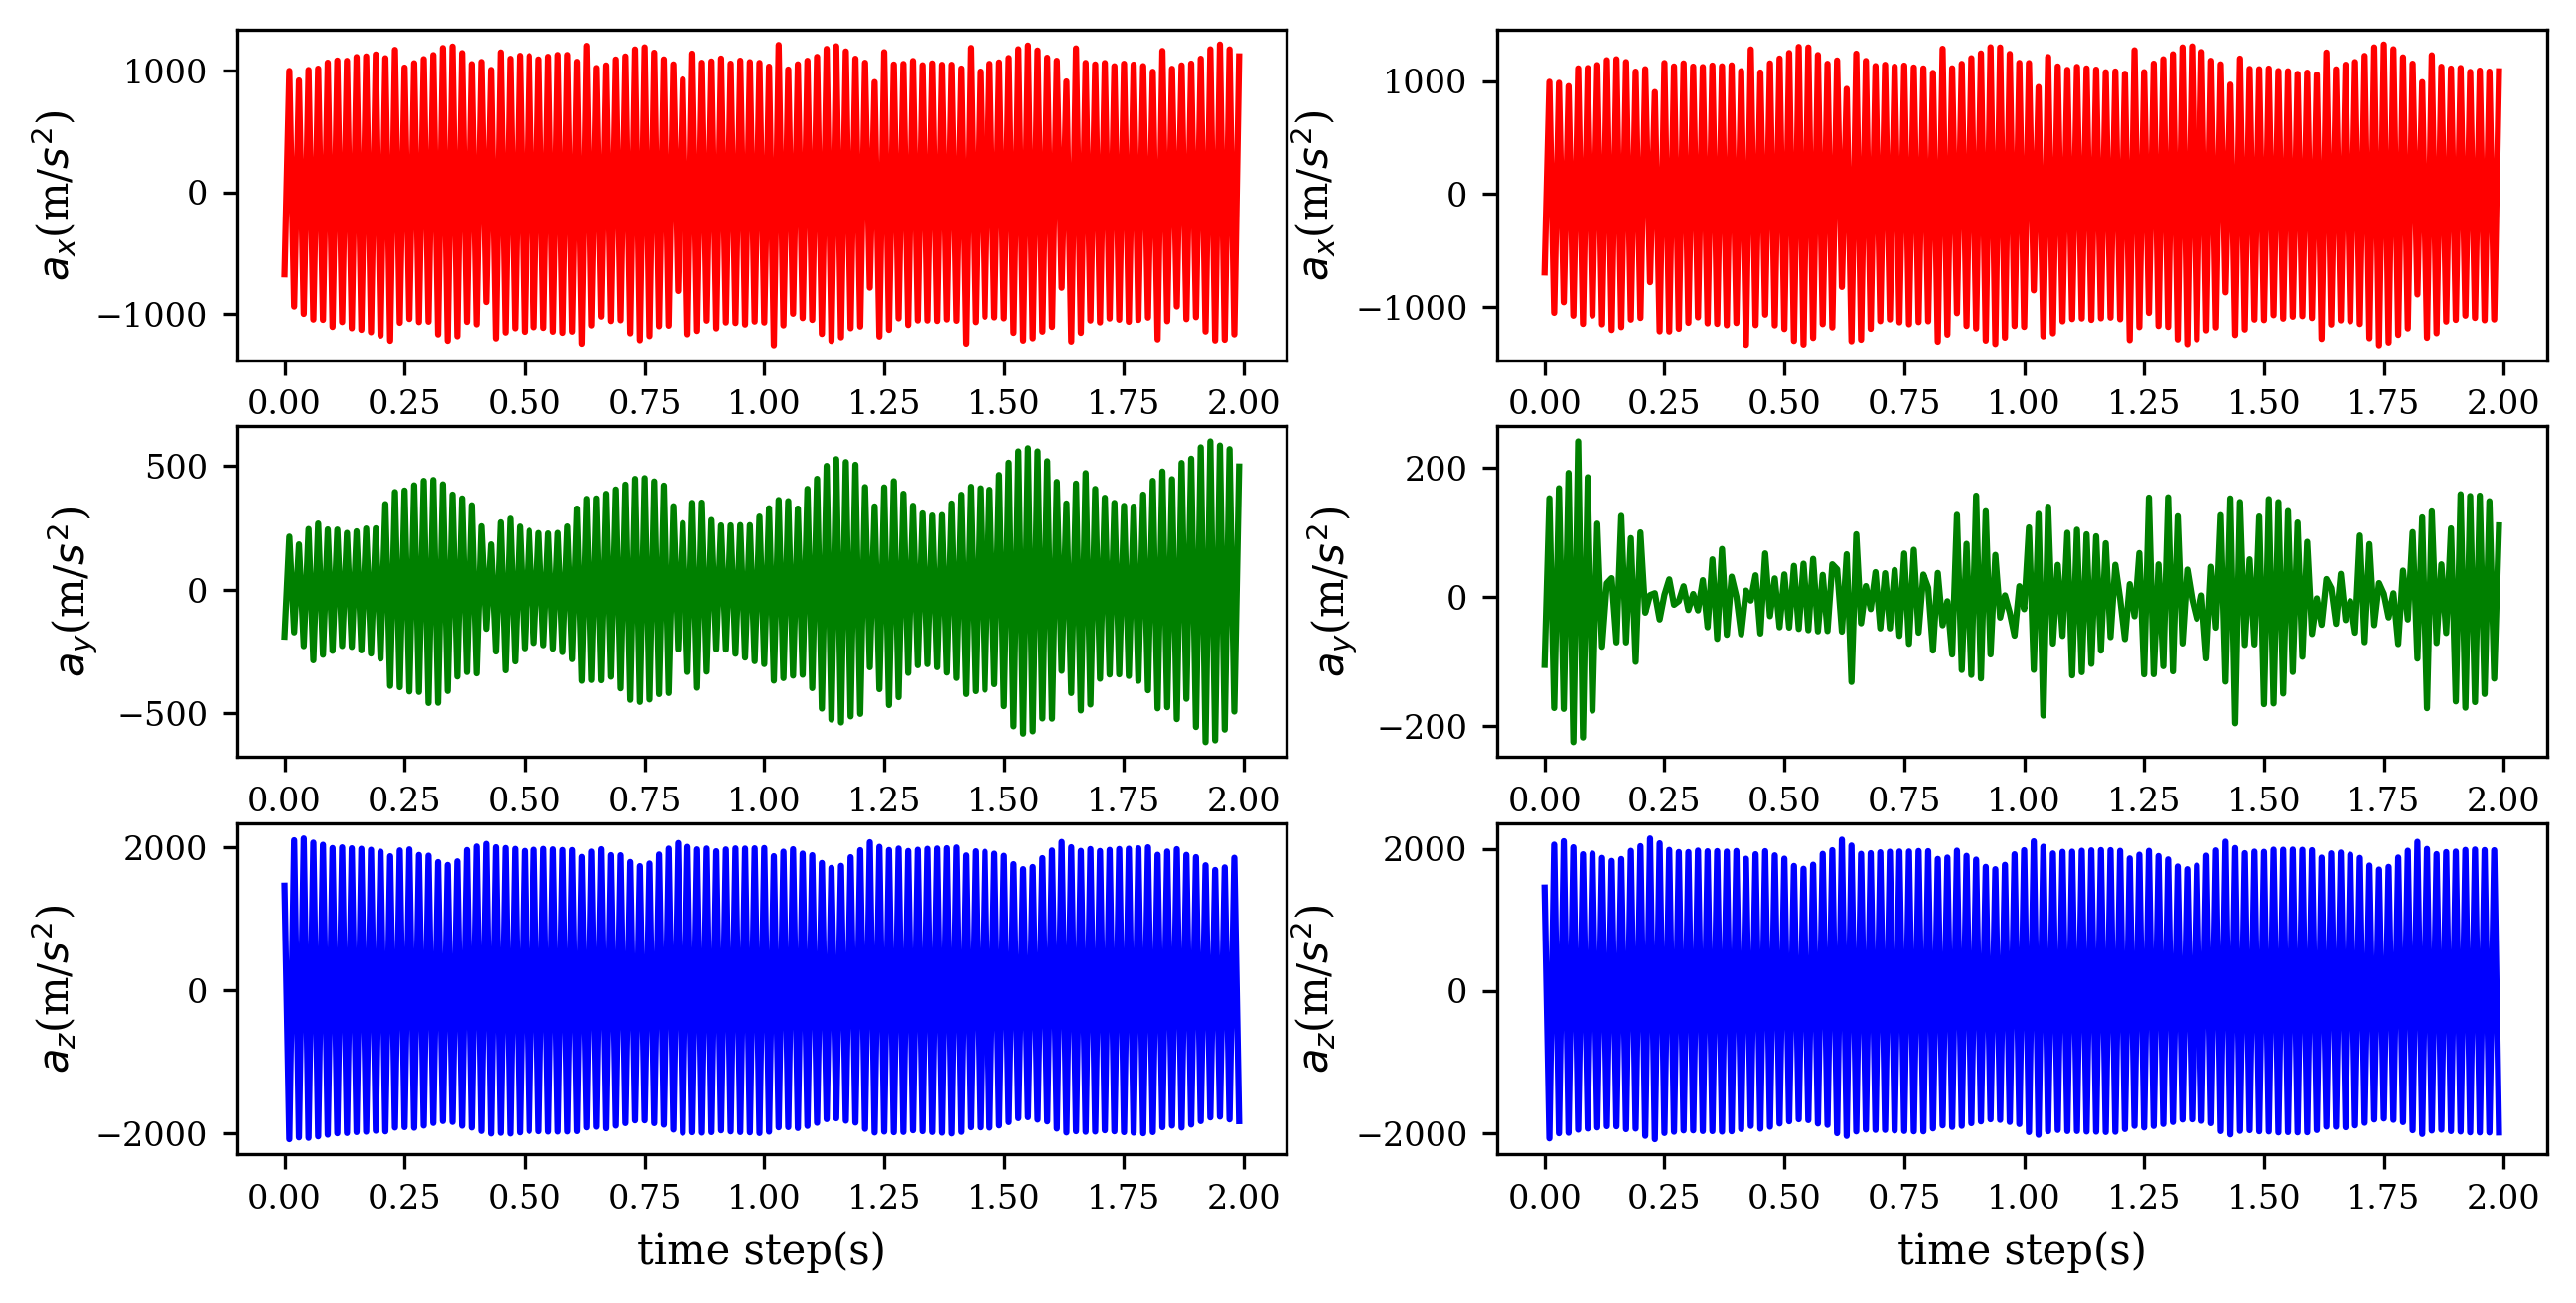

In [60]:
# left_vel = foot_vel[:, :, :4, :].mean(axis=2)
# right_vel = foot_vel[:, :, 4:, :].mean(axis=2)
# left_accel = foot_accel[:, :, :4, :].mean(axis=2)
# right_accel = foot_accel[:, :, 4:, :].mean(axis=2)

chunk_id = 0
left_vel = foot_accel[:, :, chunk_id, :]
right_vel = foot_accel[:, :, 4+chunk_id, :]
left_accel = foot_accel[:, :, chunk_id, :]
right_accel = foot_accel[:, :, 4+chunk_id, :]

left_vel_x = left_vel[:, :, 0]
left_vel_y = left_vel[:, :, 1]
left_vel_z = left_vel[:, :, 2]

right_vel_x = right_vel[:, :, 0]
right_vel_y = right_vel[:, :, 1]
right_vel_z = right_vel[:, :, 2]

left_accel_x = left_accel[:, :, 0]
left_accel_y = left_accel[:, :, 1]
left_accel_z = left_accel[:, :, 2]

right_accel_x = right_accel[:, :, 0]
right_accel_y = right_accel[:, :, 1]
right_accel_z = right_accel[:, :, 2]

plt.figure(figsize=(10, 5))
use_moving_average = False
filter_size = 20
num_sample = 1

for i in range(num_sample):
    t = (5 * 1/500) * np.arange(left_vel_x[i].shape[0])
    
    left_ax = left_accel_x[i]
    left_ay = left_accel_y[i]
    left_az = left_accel_z[i]

    right_ax = right_accel_x[i]
    right_ay = right_accel_y[i]
    right_az = right_accel_z[i]
    
    cut_off = 200
    plt.subplot(3, 2, 1)
    plt.plot(t[:cut_off], left_ax[:cut_off], label="ax", color="r")
    plt.ylabel(r"$a_x$(m/$s^2$)")
    
    plt.subplot(3, 2, 2)
    plt.plot(t[:cut_off], right_ax[:cut_off], label="ax", color="r")
    plt.ylabel(r"$a_x$(m/$s^2$)")
    
    plt.subplot(3, 2, 3)
    plt.plot(t[:cut_off], left_ay[:cut_off], label="ay", color="g")
    plt.ylabel(r"$a_y$(m/$s^2$)")
    
    plt.subplot(3, 2, 4)
    plt.plot(t[:cut_off], right_ay[:cut_off], label="ay", color="g")
    plt.ylabel(r"$a_y$(m/$s^2$)")
    
    plt.subplot(3, 2, 5)
    plt.plot(t[:cut_off], left_az[:cut_off], label="az", color="b")
    plt.ylabel(r"$a_z$(m/$s^2$)")
    plt.xlabel("time step(s)")
    
    plt.subplot(3, 2, 6)
    plt.plot(t[:cut_off], right_az[:cut_off], label="az", color="b")
    plt.ylabel(r"$a_z$(m/$s^2$)")
    plt.xlabel("time step(s)")
    
# plt.savefig("foot_accel_profile.png")
plt.show()
    
